In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
num_imgs = 80000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x+width, y:y+height] = 1.  #???
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size)  #provide triangle...
            
            
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
        
imgs.shape, bboxes.shape

((80000, 16, 16), (80000, 2, 4))

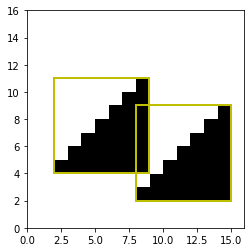

In [3]:
i = 0
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec='r' if shape[0] == 0 else 'y', fc='none'))

In [4]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((80000, 256), 3.935601844418102e-17, 1.0000000000000004)

In [5]:
# TODO: We use binary classification here - for multiple classes, convert classes to one-hot vectors.
y = np.concatenate([bboxes / img_size, shapes], axis = -1).reshape(num_imgs, -1)
print(y[:3])

[[0.5    0.125  0.4375 0.4375 1.     0.125  0.25   0.4375 0.4375 1.    ]
 [0.1875 0.4375 0.3125 0.375  0.     0.375  0.5    0.3125 0.3125 1.    ]
 [0.1875 0.5625 0.3125 0.3125 1.     0.     0.1875 0.25   0.3125 0.    ]]


In [6]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]
print(train_y[:3])

[[0.5    0.125  0.4375 0.4375 1.     0.125  0.25   0.4375 0.4375 1.    ]
 [0.1875 0.4375 0.3125 0.375  0.     0.375  0.5    0.3125 0.3125 1.    ]
 [0.1875 0.5625 0.3125 0.3125 1.     0.     0.1875 0.25   0.3125 0.    ]]


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.6), 
        Dense(y.shape[-1])
    ])
#model.compile('adadelta', 'mse')#by author
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])#by Clio
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 68,362
Trainable params: 68,362
Non-trainable params: 0
_________________________________________________________________


In [8]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    w_I = max(w_I, 0)  # set w_I and h_I zero if there is no intersection
    h_I = max(h_I, 0)
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [9]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

In [10]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 

num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious = np.zeros((len(flipped_train_y), num_epochs))
dists = np.zeros((len(flipped_train_y), num_epochs))
shape_accuracy = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print ('Epoch: ', epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 2,
              callbacks = [ModelCheckpoint('Two_Rectangles_or_Triangles_model.h5',
                                           monitor = 'val_loss',
                                           save_best_only = True)])
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[5:], exp_bboxes[:5]])
        #if i < 3:
        #    print("flipped_exp_bboxes = \n", flipped_exp_bboxes, "\nexp_bboxes = \n", exp_bboxes)
        #    print("exp_bboxes", exp_bboxes, "\n", exp_bboxes[0:4])
        #    print("flipped_exp_bboxes: ", flipped_exp_bboxes, "\n", flipped_exp_bboxes[1:5])
        mse = np.mean(np.square(pred_bboxes[0:4] - exp_bboxes[0:4]) + np.square(pred_bboxes[5:9] - exp_bboxes[5:9]))
        mse_flipped = np.mean(np.square(pred_bboxes[0:4] - flipped_exp_bboxes[0:4]) + np.square(pred_bboxes[5:9] - flipped_exp_bboxes[5:9]))
        
        #if i < 3:
        #    print("mse = ", mse, "\nmse_flipped = ", mse_flipped)
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[5:], exp_bboxes[5:])
        iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[1:5]) + IOU(pred_bboxes[5:], flipped_exp_bboxes[6:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[5:], exp_bboxes[5:])
        dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[5:], flipped_exp_bboxes[5:])
        
        #if i < 3:
        #    print("pred_bboxes[:4] = ", pred_bboxes[:4], "\t[5:9] = ", pred_bboxes[5:9])
        #    print("exp_bboxes[:4] = ", exp_bboxes[:4], "\t[5:9] = ", exp_bboxes[5:9])
        #    print("flipped_exp_bboxes[:4] = ", flipped_exp_bboxes[:4], " flipped_exp_bboxes[5:] = ", flipped_exp_bboxes[5:])
        
        shape = np.sqrt(np.square(pred_bboxes[4] - exp_bboxes[4]) + np.square(pred_bboxes[9] - exp_bboxes[9]))
        shape_flipped = np.sqrt(np.square(pred_bboxes[4] - exp_bboxes[4]) + np.square(pred_bboxes[9] - flipped_exp_bboxes[9]))
        
        if mse_flipped < mse:  # using iou or dist here leads to similar results
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            ious[i, epoch] = iou_flipped / 2.
            dists[i, epoch] = dist_flipped / 2.
            shape_accuracy[i, epoch] = shape_flipped
        else:
            ious[i, epoch] = iou / 2.
            dists[i, epoch] = dist / 2.
            shape_accuracy[i, epoch] = shape
            
        #print("------------------------------")
    print ('Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.))
    print ('Mean IOU: {}'.format(np.mean(ious[:, epoch])))
    print ('Mean dist: {}'.format(np.mean(dists[:, epoch])))
    print ('shape detect: {}'.format(np.mean(shape_accuracy[:, epoch])))

Epoch:  0
2000/2000 - 3s - loss: 0.0944 - accuracy: 0.3130 - val_loss: 0.0530 - val_accuracy: 0.3080
Flipped 31412.0 training samples (49.08125 %)
Mean IOU: 0.13985445968982227
Mean dist: 0.2067288903367093
shape detect: 0.5946461323915417
Epoch:  1
2000/2000 - 2s - loss: 0.0542 - accuracy: 0.3634 - val_loss: 0.0491 - val_accuracy: 0.4124
Flipped 17852.0 training samples (27.89375 %)
Mean IOU: 0.21302925694048275
Mean dist: 0.20770282193907202
shape detect: 0.544053584014483
Epoch:  2
2000/2000 - 2s - loss: 0.0485 - accuracy: 0.4403 - val_loss: 0.0496 - val_accuracy: 0.4436
Flipped 8996.0 training samples (14.05625 %)
Mean IOU: 0.29964406147951267
Mean dist: 0.22219041801871678
shape detect: 0.49461320926061075
Epoch:  3
2000/2000 - 2s - loss: 0.0440 - accuracy: 0.4845 - val_loss: 0.0507 - val_accuracy: 0.4038
Flipped 6545.0 training samples (10.2265625 %)
Mean IOU: 0.33868756817259177
Mean dist: 0.23712959109876935
shape detect: 0.47151197348473894
Epoch:  4
2000/2000 - 2s - loss: 0.0

Flipped 2126.0 training samples (3.321875 %)
Mean IOU: 0.4370697991751448
Mean dist: 0.2626277893017217
shape detect: 0.3376276326652768
Epoch:  33
2000/2000 - 2s - loss: 0.0307 - accuracy: 0.6035 - val_loss: 0.0534 - val_accuracy: 0.4024
Flipped 2074.0 training samples (3.2406249999999996 %)
Mean IOU: 0.4283428738352768
Mean dist: 0.26324391417763365
shape detect: 0.3438899391795547
Epoch:  34
2000/2000 - 3s - loss: 0.0308 - accuracy: 0.6030 - val_loss: 0.0538 - val_accuracy: 0.4136
Flipped 1806.0 training samples (2.821875 %)
Mean IOU: 0.4110494404504858
Mean dist: 0.25676242607805666
shape detect: 0.33959819138291547
Epoch:  35
2000/2000 - 2s - loss: 0.0307 - accuracy: 0.6059 - val_loss: 0.0529 - val_accuracy: 0.4641
Flipped 1970.0 training samples (3.078125 %)
Mean IOU: 0.42362544503981364
Mean dist: 0.25759720762907856
shape detect: 0.3434153393302606
Epoch:  36
2000/2000 - 2s - loss: 0.0307 - accuracy: 0.6042 - val_loss: 0.0546 - val_accuracy: 0.3879
Flipped 2123.0 training sampl

Text(0, 0.5, 'Training sample')

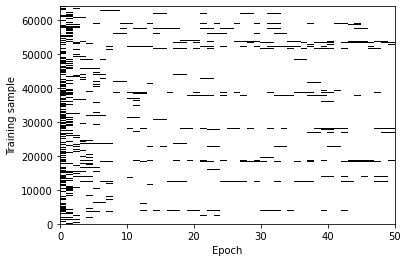

In [11]:
plt.pcolor(flipped[:, :10000], cmap='Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0.0, 1.0)

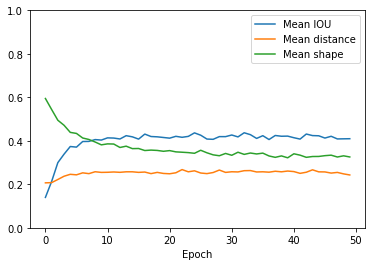

In [13]:
plt.plot(np.mean(ious, axis=0), label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(np.mean(dists, axis=0), label='Mean distance')  # relative to image size
plt.plot(np.mean(shape_accuracy, axis=0), label='Mean shape') 
plt.legend()
plt.xlabel('Epoch')
plt.ylim(0, 1)

In [14]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((16000, 2, 4), (16000, 2, 1))

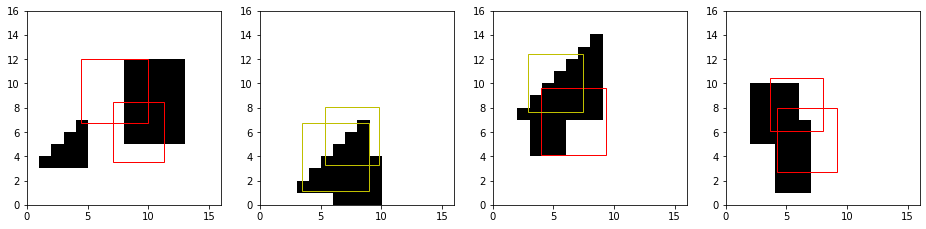

In [15]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r' if pred_shape[0] <= 0.5 else 'y', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

# plt.savefig('plots/bw-two-rectangles-or-triangles4.png', dpi=300)